In [ ]:
# !pip install transformers

In [1]:
import os, gc, sys, time, collections, random, re
import numpy as np
import pandas as pd

from typing import Dict, Optional, Union, Any, List, Tuple

from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn

import torch.utils.data as D
from torch.utils.data.dataset import Dataset, IterableDataset
from torch.utils.data.dataloader import DataLoader

from transformers import DistilBertTokenizerFast
from transformers import DistilBertModel
from transformers import BertTokenizerFast
from transformers import BertModel
from transformers import Trainer
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers.data.processors.utils import InputFeatures
from transformers import TrainingArguments
from transformers.trainer_utils import EvalLoopOutput
from transformers.trainer import logging
from transformers.file_utils import is_torch_tpu_available, is_sagemaker_mp_enabled
from transformers.trainer_pt_utils import find_batch_size, nested_concat, nested_numpify, nested_truncate, nested_detach

### Folders and Dataframes

In [2]:
DATA_PATH = Path('/home/commonlit/data/')
assert DATA_PATH.exists()
MODELS_PATH = Path('/home/commonlit/models/')
if not MODELS_PATH.exists():
    os.mkdir(MODELS_PATH)
assert MODELS_PATH.exists()

In [3]:
!ls {DATA_PATH}

commonlit_lm		       test.csv        train_duo.csv
commonlitreadabilityprize.zip  train-orig.csv
sample_submission.csv	       train.csv


In [4]:
train_df = pd.read_csv(DATA_PATH/'train_duo.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')
sample_df = pd.read_csv(DATA_PATH/'sample_submission.csv')

In [5]:
train_df

,Unnamed: 0,index,id,url_legal,license,standard_error,excerpt,target,excerpt_shortened
0,0,1142,493b80aa7,NaN,NaN,0.571404,The Dunwich horror itself came between Lammas ...,-3.672314,The Dunwich horror itself came between Lammas ...
1,1,1769,fe44cbd14,NaN,NaN,0.644398,"The iron cylinder weighs 23 kilogrammes; but, ...",-3.655626,"The iron cylinder weighs 23 kilogrammes; but, ..."
2,2,1767,284eaa5ad,NaN,NaN,0.603819,As to surface-slope its measurement—from nearl...,-3.641414,As to surface-slope its measurement—from nearl...
3,3,1735,9e9eacb49,NaN,NaN,0.606822,"The tree is dioecious, bearing male catkins on...",-3.638385,"The tree is dioecious, bearing male catkins on..."
4,4,1854,466e33a64,NaN,NaN,0.567050,The copper even of such a conductor has been m...,-3.616792,The copper even of such a conductor has been m...
...,...,...,...,...,...,...,...,...,...
2843,2843,1080,016913371,https://www.africanstorybook.org/,CC BY 4.0,0.599600,Grandma's garden was wonderful. It was full of...,1.466629,Grandma's garden was wonderful. It was full of...
2844,2844,1028,7a1d484be,https://www.africanstorybook.org/,CC BY 4.0,0.606997,More people came to the bus stop just before 9...,1.504669,More people came to the bus stop just before 9...
2845,2845,822,8f35441e3,https://www.africanstorybook.org/#,CC BY 4.0,0.624776,"Every day, Emeka's father took him to school i...",1.562759,"Every day, Emeka's father took him to school i..."
2846,2846,995,849971671,https://www.africanstorybook.org/,CC BY 4.0,0.596349,"For her last birthday, Sisanda had a special t...",1.590858,"For her last birthday, Sisanda had a special t..."


In [6]:
train_df[train_df['excerpt'].str.contains('Robin Hood')]

,Unnamed: 0,index,id,url_legal,license,standard_error,excerpt,target,excerpt_shortened
458,458,235,622f6215e,NaN,NaN,0.538084,About this time there was living in Nottingham...,-2.055361,About this time there was living in Nottingham...
459,459,2644,896fd296d,NaN,NaN,0.517827,We then came back to our castle; and there I f...,-2.054038,We then came back to our castle; and there I f...
838,838,234,5cb5ab998,NaN,NaN,0.478166,"When they drew near Nottingham, all the people...",-1.541831,"When they drew near Nottingham, all the people..."
839,839,2663,87197d2c7,NaN,NaN,0.470756,You may lead a child to read Rab and His Frien...,-1.541170,You may lead a child to read Rab and His Frien...
1041,1041,231,21ea485fb,NaN,NaN,0.450399,A little within the wood there was a fair cast...,-1.302944,A little within the wood there was a fair cast...
1042,1042,232,21ea485fb,NaN,NaN,0.450399,A little within the wood there was an imposing...,-1.302688,A little within the wood there was an imposing...
1620,1620,233,a04741371,NaN,NaN,0.506864,"The king dwelt for many months in Nottingham, ...",-0.714200,"The king dwelt for many months in Nottingham, ..."
1621,1621,2393,0aaac8f69,NaN,NaN,0.458041,"The introductions concluded, Hawkins followed ...",-0.713706,"The introductions concluded, Hawkins followed ..."


In [7]:
train_df[train_df['id'] == '21ea485fb']['excerpt'].values

array(['A little within the wood there was a fair castle, with a double moat, and surrounded by stout walls. Here dwelt that noble knight, Sir Richard Lee, to whom Robin Hood had lent the four hundred pounds to redeem his land.\nHe saw the little company of outlaws fighting their way along, so he hastened to call them to come and take shelter in his castle.\n"Welcome art thou, Robin Hood! Welcome!" he cried, as he led them in. "Much I thank thee for thy comfort and courtesy and great kindness to me in the forest. There is no man in the world I love so much as thee. For all the proud Sheriff of Nottingham, here thou shalt be safe!—Shut the gates, and draw the bridge, and let no man come in!" he shouted to his retainers. "Arm you well; make ready; guard the walls! One thing, Robin, I promise thee: here shalt thou stay for twelve days as my guest, to sup, and eat, and dine."\nSwiftly and readily tables were laid and cloths spread, and Robin Hood and his merry men sat down to a good meal.\

In [8]:
train_df[train_df['id'] == '0bf29d257']['target']

23   -3.352197
24   -3.351956
Name: target, dtype: float64

In [9]:
train_df['excerpt_shortened'] = train_df['excerpt'].apply(lambda t: re.sub(r'(.+\.).+', r'\1',  t))

In [10]:
train_df['excerpt_shortened'].values[0]

"The Dunwich horror itself came between Lammas and the equinox in 1928, and Dr. Armitage was among those who witnessed its monstrous prologue. He had heard, meanwhile, of Whateley's grotesque trip to Cambridge, and of his frantic efforts to borrow or copy from the Necronomicon at the Widener Library. Those efforts had been in vain, since Armitage had issued warnings of the keenest intensity to all librarians having charge of the dreaded volume.\nEarly in August the half-expected outcome developed, and in the small hours of the third Dr. Armitage was awakened suddenly by the wild, fierce cries of the savage watchdog on the college campus. Deep and terrible, the snarling, half-mad growls and barks continued; always in mounting volume, but with hideously significant pauses.\nThe commutator is peculiar, consisting of only three segments of a copper ring, while in the simplest of other continuous current generators several times that number exist, and frequently 120! segments are to be foun

### Normalize

In [11]:
train_df['target'].describe()

count    2848.000000
mean       -0.958295
std         1.031818
min        -3.672314
25%        -1.686362
50%        -0.907955
75%        -0.203294
max         1.654630
Name: target, dtype: float64

In [12]:
train_target_mean = train_df['target'].mean()
train_target_std = train_df['target'].std()
train_df['normalized_target'] = (train_df['target'] - train_target_mean) / train_target_std

In [13]:
train_target_mean, train_target_std

(-0.9582950780537218, 1.0318182993253338)

In [14]:
train_df['normalized_target'].describe()

count    2.848000e+03
mean    -7.983626e-17
std      1.000000e+00
min     -2.630326e+00
25%     -7.056157e-01
50%      4.878819e-02
75%      7.317187e-01
max      2.532350e+00
Name: normalized_target, dtype: float64

In [15]:
train_df['normalized_target_check'] = train_df['normalized_target'] * train_target_std + train_target_mean

In [16]:
train_df.head(30)

,Unnamed: 0,index,id,url_legal,license,standard_error,excerpt,target,excerpt_shortened,normalized_target,normalized_target_check
0,0,1142,493b80aa7,NaN,NaN,0.571404,The Dunwich horror itself came between Lammas ...,-3.672314,The Dunwich horror itself came between Lammas ...,-2.630326,-3.672314
1,1,1769,fe44cbd14,NaN,NaN,0.644398,"The iron cylinder weighs 23 kilogrammes; but, ...",-3.655626,"The iron cylinder weighs 23 kilogrammes; but, ...",-2.614153,-3.655626
2,2,1767,284eaa5ad,NaN,NaN,0.603819,As to surface-slope its measurement—from nearl...,-3.641414,As to surface-slope its measurement—from nearl...,-2.600379,-3.641414
3,3,1735,9e9eacb49,NaN,NaN,0.606822,"The tree is dioecious, bearing male catkins on...",-3.638385,"The tree is dioecious, bearing male catkins on...",-2.597443,-3.638385
4,4,1854,466e33a64,NaN,NaN,0.567050,The copper even of such a conductor has been m...,-3.616792,The copper even of such a conductor has been m...,-2.576517,-3.616792
5,5,1657,ee7d40251,NaN,NaN,0.588952,We have frequent inquiries as to the best mean...,-3.591060,We have frequent inquiries as to the best mean...,-2.551578,-3.591060
6,6,507,f18969199,https://en.wikipedia.org/wiki/Molecular_nanote...,CC BY-SA 3.0,0.643309,Molecular nanotechnology (MNT) is a technology...,-3.567280,Molecular nanotechnology (MNT) is a technology...,-2.528531,-3.567280
7,7,1833,85b41606e,NaN,NaN,0.609348,"As soon as the plate is dry, a positive cliché...",-3.546589,"As soon as the plate is dry, a positive cliché...",-2.508478,-3.546589
8,8,1842,1f8e17b78,NaN,NaN,0.549034,Reservoir.--An ordinary inverted bell-glass wi...,-3.541709,Reservoir.--An ordinary inverted bell-glass wi...,-2.503749,-3.541709
9,9,1637,99a602911,NaN,NaN,0.595653,The soil most suitable for the full developmen...,-3.535558,The soil most suitable for the full developmen...,-2.497788,-3.535558


In [17]:
# !pip install seaborn

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target'>

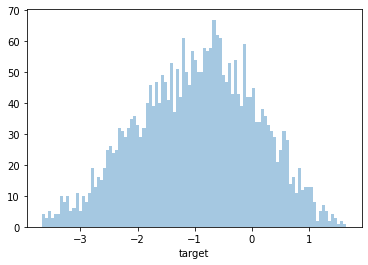

In [19]:
sns.distplot(train_df['target'],bins=100,kde=False)

### Configuration

In [20]:
import yaml

In [21]:
class CONFIG():
    batch_size = 24
    max_len = 512
    num_workers = 4
    epochs = 30
    pretrained_transformers_model = f'roberta-base'
    target_field = 'normalized_target'

In [22]:
cfg = CONFIG()
cfg.model_name = 'roberta-base'
cfg.num_folds = 6

In [23]:
cfg.train_target_std = float(train_target_std)
cfg.train_target_mean = float(train_target_mean)

In [24]:
# assert Path(cfg.pretrained_transformers_model).exists()

In [25]:
vars(cfg)

{'model_name': 'roberta-base',
 'num_folds': 6,
 'train_target_std': 1.0318182993253338,
 'train_target_mean': -0.9582950780537218}

In [26]:
!mkdir {MODELS_PATH}/facebook

mkdir: cannot create directory ‘/home/commonlit/models/facebook’: File exists


In [27]:
with open(f'{MODELS_PATH}/{cfg.model_name}.yaml', 'w') as file:
    documents = yaml.dump(vars(cfg), file)

### Prepare Cross Validation

In [28]:
target = train_df[cfg.target_field].to_numpy()

In [29]:
num_bins = int(np.floor(np.log2(len(train_df))) + 1)
train_df.loc[:, 'bins'] = pd.cut(train_df[cfg.target_field], bins=num_bins, labels=False)

In [30]:
train_df[[cfg.target_field, 'bins']].groupby(['bins']).agg(['mean', 'count'])

normalized_target      
                  mean count
bins                        
0            -2.376825    43
1            -1.956596    77
2            -1.529617   169
3            -1.125716   264
4            -0.686932   365
5            -0.255735   406
6             0.177576   480
7             0.593139   407
8             1.012727   321
9             1.429633   198
10            1.846363    93
11            2.264230    25

In [31]:
kf = StratifiedKFold(n_splits=cfg.num_folds)

In [32]:
for i, (t_, v_) in enumerate(kf.split(X=train_df, y=train_df.bins.values)):
    train_df.loc[v_, 'kfold'] = i

In [33]:
train_df['kfold'] = train_df['kfold'].astype(np.uint8)

In [34]:
train_df = train_df.drop('bins', axis=1)

In [35]:
train_df

,Unnamed: 0,index,id,url_legal,license,standard_error,excerpt,target,excerpt_shortened,normalized_target,normalized_target_check,kfold
0,0,1142,493b80aa7,NaN,NaN,0.571404,The Dunwich horror itself came between Lammas ...,-3.672314,The Dunwich horror itself came between Lammas ...,-2.630326,-3.672314,0
1,1,1769,fe44cbd14,NaN,NaN,0.644398,"The iron cylinder weighs 23 kilogrammes; but, ...",-3.655626,"The iron cylinder weighs 23 kilogrammes; but, ...",-2.614153,-3.655626,0
2,2,1767,284eaa5ad,NaN,NaN,0.603819,As to surface-slope its measurement—from nearl...,-3.641414,As to surface-slope its measurement—from nearl...,-2.600379,-3.641414,0
3,3,1735,9e9eacb49,NaN,NaN,0.606822,"The tree is dioecious, bearing male catkins on...",-3.638385,"The tree is dioecious, bearing male catkins on...",-2.597443,-3.638385,0
4,4,1854,466e33a64,NaN,NaN,0.567050,The copper even of such a conductor has been m...,-3.616792,The copper even of such a conductor has been m...,-2.576517,-3.616792,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2843,2843,1080,016913371,https://www.africanstorybook.org/,CC BY 4.0,0.599600,Grandma's garden was wonderful. It was full of...,1.466629,Grandma's garden was wonderful. It was full of...,2.350146,1.466629,4
2844,2844,1028,7a1d484be,https://www.africanstorybook.org/,CC BY 4.0,0.606997,More people came to the bus stop just before 9...,1.504669,More people came to the bus stop just before 9...,2.387013,1.504669,5
2845,2845,822,8f35441e3,https://www.africanstorybook.org/#,CC BY 4.0,0.624776,"Every day, Emeka's father took him to school i...",1.562759,"Every day, Emeka's father took him to school i...",2.443312,1.562759,5
2846,2846,995,849971671,https://www.africanstorybook.org/,CC BY 4.0,0.596349,"For her last birthday, Sisanda had a special t...",1.590858,"For her last birthday, Sisanda had a special t...",2.470545,1.590858,5


In [36]:
train_df[[cfg.target_field, 'kfold']].groupby(['kfold']).agg(['mean', 'count'])

normalized_target      
                   mean count
kfold                        
0             -0.182338   475
1             -0.104118   475
2             -0.031442   475
3              0.039392   475
4              0.103799   474
5              0.175294   474

In [37]:
bin_list = list(range(num_bins))
random.shuffle(bin_list)
bin_list

[11, 5, 9, 0, 2, 8, 10, 1, 7, 3, 4, 6]

In [38]:
train_df['normalized_target'].mean()

-7.983626244495507e-17

### Metrics

In [39]:
def rmse_score(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

def rmse_score_2(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [40]:
a = np.random.rand(10)
b = np.random.rand(10)

In [41]:
rmse_score(a, b), rmse_score_2(a, b)

(0.3853643949192, 0.3853643949192)

### Prepare train test split

In [42]:
text_field = 'excerpt_shortened'

def create_split(fold = [1]):
    valid_df = train_df[train_df['kfold'].isin(fold)]
    valid_text = valid_df[text_field].values
    valid_target = valid_df[cfg.target_field].values
    training_df = train_df[~train_df['kfold'].isin(fold)]
    train_text = training_df[text_field].values
    train_target = training_df[cfg.target_field].values
    return train_text, train_target, valid_text, valid_target

In [43]:
train_text, train_target, valid_text, valid_target = create_split([0])
len(train_text), len(valid_text)

(2373, 475)

### Prepare Tokenizers

In [44]:
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)
# Save the tokenizer so that you can download the files and move it to a Kaggle dataset.
# tokenizer.save_pretrained(cfg.save_dir)

In [45]:
encoded_dict = tokenizer(train_df[text_field].values[0],
                                return_tensors='pt',
                                max_length=cfg.max_len,
                                padding='max_length',
                                truncation=True,
                                return_token_type_ids=True)
decoded = tokenizer.decode(encoded_dict["input_ids"].squeeze())
decoded

"<s>The Dunwich horror itself came between Lammas and the equinox in 1928, and Dr. Armitage was among those who witnessed its monstrous prologue. He had heard, meanwhile, of Whateley's grotesque trip to Cambridge, and of his frantic efforts to borrow or copy from the Necronomicon at the Widener Library. Those efforts had been in vain, since Armitage had issued warnings of the keenest intensity to all librarians having charge of the dreaded volume.\nEarly in August the half-expected outcome developed, and in the small hours of the third Dr. Armitage was awakened suddenly by the wild, fierce cries of the savage watchdog on the college campus. Deep and terrible, the snarling, half-mad growls and barks continued; always in mounting volume, but with hideously significant pauses.\nThe commutator is peculiar, consisting of only three segments of a copper ring, while in the simplest of other continuous current generators several times that number exist, and frequently 120! segments are to be f

In [46]:
encoded_dict.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [47]:
encoded_dict.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [48]:
encoded_dict['input_ids'].shape

torch.Size([1, 512])

In [49]:
def convert_to_list(t):
    return t.flatten().long()

class CommonLitDataset(nn.Module):
    def __init__(self, text, target, tokenizer, max_len=128):
        self.excerpt = text
        self.target = target
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self, idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        return InputFeatures(input_ids=convert_to_list(encode['input_ids']),
                      attention_mask=convert_to_list(encode['attention_mask']),
                      label=torch.tensor(self.target[idx]))
    
    def __len__(self):
        return len(self.excerpt)

In [50]:
def create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target):
    train_ds = CommonLitDataset(train_text, train_target, tokenizer, cfg.max_len)
    valid_ds = CommonLitDataset(valid_text, valid_target, tokenizer, cfg.max_len)
    return train_ds, valid_ds

In [51]:
# encode.keys(), target.shape, encode['input_ids'].shape, encode['attention_mask'].shape

In [52]:
# encode['input_ids'][0].squeeze()

### Model

In [53]:
# You can use a Transformer model of your choice.
# transformer_model = DistilBertModel.from_pretrained(cfg.pretrained_transformers_model)
transformer_model = AutoModelForSequenceClassification.from_pretrained(cfg.pretrained_transformers_model)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [54]:
# transformer_out = transformer_model(input_ids=encode['input_ids'].squeeze(), attention_mask=encode['attention_mask'].squeeze())

In [55]:
# dict(transformer_out)['last_hidden_state'].shape

In [56]:
# torch.mean(transformer_out.last_hidden_state, axis=1).shape

In [57]:
# sample_layer = nn.Linear(768, 1)

In [58]:
model_config = AutoConfig.from_pretrained(cfg.pretrained_transformers_model)

In [59]:
model_config

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [60]:
from torch.nn import functional as F

In [61]:
from transformers import PreTrainedModel

class CommonLitModel(PreTrainedModel):
    def __init__(self):
        super(PreTrainedModel, self).__init__()
        self.transformer_model = AutoModel.from_pretrained(cfg.pretrained_transformers_model)
        self.drop = nn.Dropout(0.5)
        self.config = AutoConfig.from_pretrained(cfg.pretrained_transformers_model)
        self.layer_norm = nn.LayerNorm(self.config.hidden_size)
        self.out = nn.Linear(self.config.hidden_size, 1)
        self._init_weights(self.layer_norm)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def forward(self, input_ids, attention_mask):
        transformer_out = self.transformer_model(input_ids=input_ids.squeeze(), attention_mask=attention_mask.squeeze(), 
                                                 output_hidden_states=True)
        x = transformer_out.pooler_output
#         x = transformer_out.last_hidden_state[:, 0, :] # N, C, X
#         x = torch.mean(transformer_out.hidden_states[-2], axis=1)
#         x2 = torch.mean(transformer_out.encoder_hidden_states[-2], axis=1)
#         x = torch.cat([x, x2], axis=1)
        x = self.layer_norm(x)
        x = self.drop(x)
        x = self.out(x)
        return x
    
    def floating_point_ops(self, inputs: Dict[str, Union[torch.Tensor, Any]]):
        """
        For models that inherit from :class:`~transformers.PreTrainedModel`, uses that method to compute the number of
        floating point operations for every backward + forward pass. If using another model, either implement such a
        method in the model or subclass and override this method.
        Args:
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.
        Returns:
            :obj:`int`: The number of floating-point operations.
        """
        return 0

In [62]:
model = CommonLitModel()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [63]:
encoded_dict.token_type_ids

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0

In [64]:
encoded_dict.token_type_ids.shape

torch.Size([1, 512])

In [65]:
transformer_model = transformer_model.cuda()
sample_out = transformer_model(encoded_dict.input_ids.cuda(), encoded_dict.attention_mask.cuda(), encoded_dict.token_type_ids.cuda(), output_hidden_states=True)

In [66]:
sample_out.keys()

odict_keys(['logits', 'hidden_states'])

In [67]:
sample_x = torch.mean(sample_out.hidden_states[-1], axis=1)

In [68]:
torch.cat([sample_x, sample_x], axis=1).shape

torch.Size([1, 1536])

In [69]:
sample_out.logits.shape

torch.Size([1, 2])

In [70]:
sample_out.hidden_states[-1].shape, sample_out.hidden_states[-1][:, 0, :].shape

(torch.Size([1, 512, 768]), torch.Size([1, 768]))

In [71]:
train_ds, valid_ds = create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target)

In [72]:
encode = train_ds[0]

In [73]:
encode.attention_mask.unsqueeze(0).shape, encoded_dict.input_ids.shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [74]:
sample_out = transformer_model(encode.input_ids.unsqueeze(0).cuda(), encode.attention_mask.unsqueeze(0).cuda())

### Training

In [75]:
import wandb

In [76]:
criterion = nn.MSELoss()

kl_loss = nn.KLDivLoss(reduction = 'batchmean')

def loss_fct(yhat, y):
    return criterion(yhat, y) * 0.7 + 0.3 * kl_loss(yhat, y)

loss_fct = nn.MSELoss()

def loss_fct(yhat, y):
    return torch.sqrt(criterion(yhat, y))

In [77]:
def create_training_args(fold):
    training_args = TrainingArguments(
        output_dir=str(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{fold}"),
        overwrite_output_dir=True,
        do_train=True,
        do_eval=True,
        per_device_train_batch_size=cfg.batch_size,
        per_device_eval_batch_size=cfg.batch_size,
        num_train_epochs=cfg.epochs,
        logging_strategy="epoch",
        logging_first_step=True,
        save_steps=40000,
        fp16=True,
        evaluation_strategy="epoch",
        save_total_limit = 3,
        load_best_model_at_end=True,
        metric_for_best_model='mse',
        greater_is_better=False,
        gradient_accumulation_steps=1,
        learning_rate=5e-5
    )
    return training_args

In [78]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return {'mse': mean_squared_error(logits, labels), 'rmse': rmse_score_2(logits, labels)}

In [79]:
tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)

In [80]:
logger = logging.get_logger(__name__)

class CommonLitTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        input_ids = inputs.pop("input_ids")
        attention_mask = inputs.pop("attention_mask")
        outputs = model(input_ids, attention_mask)
        logits = outputs
        loss = loss_fct(logits.flatten(),
                        labels.float().flatten())
        zero_cat = torch.zeros([1, 1]).to(outputs.device)
        return (loss, torch.cat([zero_cat, outputs])) if return_outputs else loss

In [81]:
!rm -rf /home/commonlit/models/{cfg.model_name.replace('/', '_')}-*

In [82]:
%%time

from transformers import EarlyStoppingCallback

bin_step = 1
bestmodels = []
eval_rmses = []
for i in range(0, cfg.num_folds, bin_step):
    train_bins = bin_list[i:i+bin_step]
    print('train_bins', f'{i}: {train_bins}')
    tokenizer = AutoTokenizer.from_pretrained(cfg.pretrained_transformers_model)
    train_text, train_target, valid_text, valid_target = create_split([i])
    train_ds, valid_ds = create_train_valid_ds(tokenizer, train_text, train_target, valid_text, valid_target)
    training_args = create_training_args(i)
    model = CommonLitModel()
    wandb.init(project=f"commonlit_{cfg.model_name.replace('/', '_')}")
    trainer = CommonLitTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=12)]
    )
    trainer.train()
    trainer.save_model()
    print('training_args.output_dir', training_args.output_dir)
    tokenizer.save_pretrained(training_args.output_dir)
    result = trainer.evaluate()
    bestmodels.append(trainer.state.best_model_checkpoint)
    print('best_model_checkpoint', trainer.state.best_model_checkpoint)
    print('result', result)
    eval_rmses.append(result['eval_rmse'])

train_bins 0: [11]


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
wandb: Currently logged in as: gilf (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.766200,0.528551,0.299893,0.547625
2,0.556200,0.390989,0.160862,0.401076
3,0.462400,0.385343,0.161275,0.401591
4,0.403800,0.474764,0.236813,0.486634
5,0.390800,0.491414,0.260298,0.510194
6,0.346600,0.541803,0.323101,0.568420
7,0.322900,0.589074,0.399202,0.631825
8,0.309400,0.475152,0.248312,0.498309
9,0.291000,0.641253,0.438663,0.662316
10,0.269100,0.547502,0.318922,0.564732


training_args.output_dir /home/commonlit/models/roberta-base-0


best_model_checkpoint /home/commonlit/models/roberta-base-0/checkpoint-198
result {'eval_loss': 0.3909892737865448, 'eval_mse': 0.16086174547672272, 'eval_rmse': 0.40107572078704834, 'eval_runtime': 5.6677, 'eval_samples_per_second': 83.809, 'epoch': 14.0, 'eval_mem_cpu_alloc_delta': 8192, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 1246061056}
train_bins 1: [5]


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.2276
train/learning_rate,3e-05
train/epoch,14.0
train/global_step,1386
_runtime,782
_timestamp,1624009733
_step,30
eval/loss,0.39099
eval/mse,0.16086
eval/rmse,0.40108
eval/runtime,5.6677


train/loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
train/learning_rate,██▇▇▆▆▅▅▄▄▃▃▂▂▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
eval/loss,▅▁▁▃▄▅▇▃█▅▃▂▇▄▁
eval/mse,▅▁▁▃▄▅▇▃█▅▃▁▇▄▁
eval/rmse,▅▁▁▃▄▅▇▄█▅▃▁▇▅▁
eval/runtime,▁▄▆▆▇▇▇▆▇▆▇▆▆█▆


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.765000,0.642331,0.438686,0.662334
2,0.589900,0.406958,0.182210,0.426860
3,0.496800,0.399000,0.175040,0.418378
4,0.448900,0.477280,0.243517,0.493474
5,0.373100,0.627085,0.438083,0.661878
6,0.358200,0.531099,0.328275,0.572953
7,0.331600,0.429746,0.204911,0.452671
8,0.310100,0.465822,0.231045,0.480672
9,0.302900,0.567944,0.342741,0.585441
10,0.290300,0.442688,0.217455,0.466321


training_args.output_dir /home/commonlit/models/roberta-base-1


best_model_checkpoint /home/commonlit/models/roberta-base-1/checkpoint-297
result {'eval_loss': 0.3990003764629364, 'eval_mse': 0.17504021525382996, 'eval_rmse': 0.418378084897995, 'eval_runtime': 5.6724, 'eval_samples_per_second': 83.739, 'epoch': 15.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 1246061056}
train_bins 2: [9]


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.2172
train/learning_rate,3e-05
train/epoch,15.0
train/global_step,1485
_runtime,839
_timestamp,1624010587
_step,32
eval/loss,0.399
eval/mse,0.17504
eval/rmse,0.41838
eval/runtime,5.6724


train/loss,█▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁
train/learning_rate,██▇▇▆▆▅▅▄▄▃▃▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
eval/loss,█▁▁▃█▅▂▃▆▂▁▂▁▂▄▁
eval/mse,█▁▁▃█▅▂▂▅▂▁▂▁▂▄▁
eval/rmse,█▁▁▃█▅▂▃▆▂▁▂▂▂▄▁
eval/runtime,▅▃▄▇▃█▃▅▃▄▄▇▅▇▅▁


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.833400,0.480693,0.254882,0.504858
2,0.578500,0.401100,0.182877,0.427641
3,0.497200,0.423085,0.197200,0.444072
4,0.419200,0.472170,0.235363,0.485142
5,0.409300,0.390653,0.169903,0.412193
6,0.354700,0.528513,0.292019,0.540387
7,0.345600,0.374061,0.153582,0.391895
8,0.317800,0.409339,0.181334,0.425833
9,0.303600,0.393785,0.162407,0.402997
10,0.292400,0.440923,0.202613,0.450126


training_args.output_dir /home/commonlit/models/roberta-base-2


best_model_checkpoint /home/commonlit/models/roberta-base-2/checkpoint-693
result {'eval_loss': 0.37406057119369507, 'eval_mse': 0.15358179807662964, 'eval_rmse': 0.3918951451778412, 'eval_runtime': 5.6634, 'eval_samples_per_second': 83.872, 'epoch': 19.0, 'eval_mem_cpu_alloc_delta': 4096, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 1246061056}
train_bins 3: [0]


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.2134
train/learning_rate,2e-05
train/epoch,19.0
train/global_step,1881
_runtime,1057
_timestamp,1624011659
_step,40
eval/loss,0.37406
eval/mse,0.15358
eval/rmse,0.3919
eval/runtime,5.6634


train/loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▆▆▅▅▅▄▄▄▃▃▂▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
eval/loss,▆▂▃▅▂█▁▃▂▄▃▃▃▂▄▁▃▄▃▁
eval/mse,▆▂▃▅▂█▁▂▁▃▃▃▄▂▅▁▃▃▂▁
eval/rmse,▆▃▃▅▂█▁▃▂▄▃▃▄▂▅▁▃▃▂▁
eval/runtime,▃▄▆▅▅▅▃▄▅▇▇█▆▄▄▅▃▃▅▁


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.802100,0.451047,0.218222,0.467142
2,0.591100,0.403373,0.171108,0.413652
3,0.519700,0.425228,0.193390,0.439761
4,0.433200,0.391444,0.165385,0.406676
5,0.371600,0.501599,0.278326,0.527566
6,0.378700,0.417586,0.190201,0.436120
7,0.344500,0.424168,0.189774,0.435630
8,0.311300,0.459621,0.236005,0.485803
9,0.295100,0.428638,0.197259,0.444139
10,0.281400,0.432612,0.211150,0.459511


training_args.output_dir /home/commonlit/models/roberta-base-3


best_model_checkpoint /home/commonlit/models/roberta-base-3/checkpoint-1287
result {'eval_loss': 0.36811137199401855, 'eval_mse': 0.1458096206188202, 'eval_rmse': 0.3818502724170685, 'eval_runtime': 5.6963, 'eval_samples_per_second': 83.387, 'epoch': 25.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 1246061056}
train_bins 4: [2]


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.1588
train/learning_rate,1e-05
train/epoch,25.0
train/global_step,2475
_runtime,1391
_timestamp,1624013065
_step,52
eval/loss,0.36811
eval/mse,0.14581
eval/rmse,0.38185
eval/runtime,5.6963


train/loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval/loss,▅▃▄▂█▄▄▆▄▄▆▆▁▅█▁▆█▆▃▃▃▄▂▃▁
eval/mse,▅▂▄▂█▃▃▆▄▄▆▆▁▅▇▁▆▇▅▃▃▃▄▂▃▁
eval/rmse,▅▃▄▂█▄▄▆▄▅▆▆▁▅█▁▆▇▆▃▃▃▄▂▃▁
eval/runtime,▄▁▃▃▁▄▁▁▂▄▃▂█▂▂▃▁█▂▄█▄▅▅▆▄


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.843000,0.427108,0.197601,0.444524
2,0.580400,0.445090,0.237567,0.487408
3,0.480900,0.536644,0.347036,0.589097
4,0.406200,0.557588,0.358804,0.599002
5,0.363500,0.667932,0.486211,0.697288
6,0.369600,0.468470,0.252178,0.502174
7,0.324100,0.416076,0.197949,0.444915
8,0.311600,0.403567,0.174562,0.417807
9,0.288000,0.527190,0.309227,0.556081
10,0.272000,0.462802,0.237531,0.487371


training_args.output_dir /home/commonlit/models/roberta-base-4


best_model_checkpoint /home/commonlit/models/roberta-base-4/checkpoint-1287
result {'eval_loss': 0.390385240316391, 'eval_mse': 0.16964203119277954, 'eval_rmse': 0.41187623143196106, 'eval_runtime': 5.6531, 'eval_samples_per_second': 83.848, 'epoch': 25.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 1246061056}
train_bins 5: [8]


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train/loss,0.1627
train/learning_rate,1e-05
train/epoch,25.0
train/global_step,2475
_runtime,1391
_timestamp,1624014472
_step,52
eval/loss,0.39039
eval/mse,0.16964
eval/rmse,0.41188
eval/runtime,5.6531


train/loss,█▅▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval/loss,▂▂▅▅█▃▂▁▄▃▅▂▁▂▃▁▂▃▂▃▂▂▂▂▂▁
eval/mse,▂▃▅▅█▃▂▁▄▃▄▂▁▁▃▁▂▂▂▂▁▁▂▂▂▁
eval/rmse,▂▃▅▆█▃▂▁▅▃▅▂▁▁▃▁▂▃▂▃▂▂▂▂▂▁
eval/runtime,▃▆▃▃▅▅▆▂▄▇▇▂▆▇▄▄▂▃▃▂█▄▃▃▂▁


wandb: wandb version 0.10.32 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch,Training Loss,Validation Loss,Mse,Rmse
1,0.845300,0.575915,0.389345,0.623975
2,0.596500,0.445307,0.259520,0.509431
3,0.496300,0.422231,0.195115,0.441718
4,0.411700,0.380750,0.165696,0.407058
5,0.365200,0.472163,0.239327,0.489211
6,0.340600,0.514642,0.309474,0.556304
7,0.322500,0.379941,0.155083,0.393806
8,0.311100,0.395005,0.167740,0.409560
9,0.273200,0.486560,0.258599,0.508526
10,0.280700,0.404346,0.178349,0.422314


training_args.output_dir /home/commonlit/models/roberta-base-5


best_model_checkpoint /home/commonlit/models/roberta-base-5/checkpoint-1188
result {'eval_loss': 0.37011590600013733, 'eval_mse': 0.1481679528951645, 'eval_rmse': 0.384925901889801, 'eval_runtime': 5.6604, 'eval_samples_per_second': 83.74, 'epoch': 24.0, 'eval_mem_cpu_alloc_delta': 0, 'eval_mem_gpu_alloc_delta': 0, 'eval_mem_cpu_peaked_delta': 0, 'eval_mem_gpu_peaked_delta': 1246061056}
CPU times: user 2h 55min 27s, sys: 47min 12s, total: 3h 42min 40s
Wall time: 1h 57min 22s


In [83]:
'Mean best RSME losses', np.array(eval_rmses).mean()

('Mean best RSME losses', 0.3983335594336192)

### Verify the model

In [84]:
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

In [85]:
cfg.model_offset = 0
cfg.model_limit = 6
cfg.n_folds = 5
cfg.svm_kernels = ['rbf']
cfg.svm_c = 5

In [96]:
train_df = pd.read_csv(DATA_PATH/'train.csv')
test_df = pd.read_csv(DATA_PATH/'test.csv')

In [97]:
train_target_mean = train_df['target'].mean()
train_target_std = train_df['target'].std()
train_df['normalized_target'] = (train_df['target'] - train_target_mean) / train_target_std

In [98]:
num_bins = int(np.ceil(np.log2(len(train_df))))
train_df['bins'] = pd.cut(train_df['target'], bins=num_bins, labels=False)
bins = train_df['bins'].values

In [99]:
%%time

inference_models = []
for i in range(cfg.model_offset, cfg.model_limit):
    print(f'Model {i}')
    inference_model = CommonLitModel()
    inference_model = inference_model.cuda()
    inference_model.load_state_dict(torch.load(str(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{i}/pytorch_model.bin")))
    inference_model.eval();
    inference_models.append(inference_model)

Model 0


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 1


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 2


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 3


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 4


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model 5


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: user 9.13 s, sys: 2.91 s, total: 12 s
Wall time: 26.2 s


In [100]:
tokenizers = []
for i in range(cfg.model_offset, cfg.model_limit):
    tokenizer = AutoTokenizer.from_pretrained(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}-{i}")
    tokenizers.append(tokenizer)

In [101]:
def get_cls_embeddings(dl, transformer_model):
    cls_embeddings = []
    with torch.no_grad():
        for input_features in tqdm(dl, total=len(dl)):
            output = transformer_model(input_features['input_ids'].cuda(), input_features['attention_mask'].cuda())
            cls_embeddings.extend(output[0][:,0,:].detach().cpu().numpy())
    return np.array(cls_embeddings)

In [102]:
def rmse_score(X, y):
    return np.sqrt(mean_squared_error(X, y))

In [103]:
def convert_to_list(t):
    return t.flatten().long()

class CommonLitDataset(nn.Module):
    def __init__(self, text, test_id, tokenizer, max_len=128):
        self.excerpt = text
        self.test_id = test_id
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        return {'input_ids': convert_to_list(encode['input_ids']),
                'attention_mask': convert_to_list(encode['attention_mask']),
                'id': self.test_id[idx]}
    
    def __len__(self):
        return len(self.excerpt)

In [104]:
def create_dl(df, tokenizer):
    text = df['excerpt'].values
    ids = df['id'].values
    ds = CommonLitDataset(text, ids, tokenizer, max_len=cfg.max_len)
    return DataLoader(ds, 
                      batch_size = cfg.batch_size,
                      shuffle=False,
                      num_workers = 1,
                      pin_memory=True,
                      drop_last=False
                     )

In [105]:
%%time

train_target = train_df['normalized_target'].values

def calc_mean(scores):
    return np.mean(np.array(scores), axis=0)

final_scores = []
final_rmse = []
kernel_rmse_score_mean = []
for j, (inference_model, tokenizer) in enumerate(zip(inference_models, tokenizers)):
    print('Model', j)
    test_dl = create_dl(test_df, tokenizer)
    train_dl = create_dl(train_df, tokenizer)
    transformer_model = inference_model.transformer_model if hasattr(inference_model, 'transformer_model') else inference_model
    transformer_model.cuda()
    X = get_cls_embeddings(train_dl, transformer_model)
    y = train_target
    X_test = get_cls_embeddings(test_dl, transformer_model)
    kfold = StratifiedKFold(n_splits=cfg.n_folds)
    scores = []
    rmse_scores = []
    for kernel in cfg.svm_kernels:
        print('Kernel', kernel)
        kernel_scores = []
        kernel_rmse_scores = []
        for k, (train_idx, valid_idx) in enumerate(kfold.split(X, bins)):

            print('Fold', k, train_idx.shape, valid_idx.shape)
            model = SVR(C=cfg.svm_c, kernel=kernel, gamma='auto')

            X_train, y_train = X[train_idx], y[train_idx]
            X_valid, y_valid = X[valid_idx], y[valid_idx]
            model.fit(X_train, y_train)
            prediction = model.predict(X_valid)
            kernel_rmse_scores.append(rmse_score(prediction, y_valid))
            print('rmse_score', kernel_rmse_scores[k])
            kernel_scores.append(model.predict(X_test))
        scores.append(calc_mean(kernel_scores))
        kernel_rmse_score = calc_mean(kernel_rmse_scores)
        kernel_rmse_score_mean.append(kernel_rmse_score)
        rmse_scores.append(kernel_rmse_score)
    final_scores.append(calc_mean(scores))
    final_rmse.append(calc_mean(rmse_scores))
print('FINAL RMSE score', np.mean(np.array(final_rmse)))

Model 0



Kernel rbf
Fold 0 (2279,) (570,)
rmse_score 0.45586839157188835
Fold 1 (2279,) (570,)
rmse_score 0.4478322583585632
Fold 2 (2279,) (570,)
rmse_score 0.42194573073894703
Fold 3 (2279,) (570,)
rmse_score 0.45930791776621377
Fold 4 (2280,) (569,)
rmse_score 0.4487610304594554
Model 1



Kernel rbf
Fold 0 (2279,) (570,)
rmse_score 0.440093380855245
Fold 1 (2279,) (570,)
rmse_score 0.43635260136868004
Fold 2 (2279,) (570,)
rmse_score 0.39731368882278373
Fold 3 (2279,) (570,)
rmse_score 0.42903649269072247
Fold 4 (2280,) (569,)
rmse_score 0.4327009997142688
Model 2



Kernel rbf
Fold 0 (2279,) (570,)
rmse_score 0.3744396651001222
Fold 1 (2279,) (570,)
rmse_score 0.3710565496121605
Fold 2 (2279,) (570,)
rmse_score 0.35116456718062067
Fold 3 (2279,) (570,)
rmse_score 0.38346864152628507
Fold 4 (2280,) (569,)
rmse_score 0.35713083310426047
Model 3



Kernel rbf
Fold 0 (2279,) (570,)
rmse_score 0.33144303579245105
Fold 1 (2279,) (570,)
rmse_score 0.32696510782253535
Fold 2 (2279,) (570,)
rmse_score 0.30386175876974014
Fold 3 (2279,) (570,)
rmse_score 0.3318544195719857
Fold 4 (2280,) (569,)
rmse_score 0.3540809666938648
Model 4



Kernel rbf
Fold 0 (2279,) (570,)
rmse_score 0.35405613246937295
Fold 1 (2279,) (570,)
rmse_score 0.3359799199774786
Fold 2 (2279,) (570,)
rmse_score 0.30837872718288134
Fold 3 (2279,) (570,)
rmse_score 0.3392986313094793
Fold 4 (2280,) (569,)
rmse_score 0.35957740224956375
Model 5



Kernel rbf
Fold 0 (2279,) (570,)
rmse_score 0.34997106340500256
Fold 1 (2279,) (570,)
rmse_score 0.33984544147879536
Fold 2 (2279,) (570,)
rmse_score 0.29236355022547605
Fold 3 (2279,) (570,)
rmse_score 0.3565250897608336
Fold 4 (2280,) (569,)
rmse_score 0.3438175878353223
FINAL RMSE score 0.37448305278050004
CPU times: user 4min 3s, sys: 1.15 s, total: 4min 4s
Wall time: 4min 2s


In [106]:
# (train_df['target'] - cfg.train_target_mean) / cfg.train_target_std
final_scores_normalized = np.array(final_scores) * train_target_std + train_target_mean

In [107]:
kernel_rmse_score_mean_array = np.array(kernel_rmse_score_mean)
kernel_rmse_score_mean_sum = np.sum(kernel_rmse_score_mean_array)
prop_losses = kernel_rmse_score_mean_array / kernel_rmse_score_mean_sum
prop_losses_sum = (1 - prop_losses).sum()
weights = (1 - prop_losses) / prop_losses_sum
weights

array([0.16023469, 0.1619832 , 0.16729251, 0.17065812, 0.16978429,
       0.17004719])

In [108]:
def calc_mean(scores, weights=weights):
    return np.average(np.array(scores), weights=weights, axis=0)

In [109]:
target_mean = train_df['target'].mean()
final_scores_flat = calc_mean(final_scores_normalized).flatten()
final_scores_mean = final_scores_flat.mean()
target_mean, np.array(final_scores_normalized).mean()

(-0.9583035525693224, -0.9007549003323715)

In [110]:
final_scores_flat

array([-0.70057631, -0.34650067, -0.50153339, -2.47051331, -1.55480316,
       -1.12997864,  0.39292791])

In [111]:
mean_diff = target_mean - final_scores_mean
mean_diff, mean_diff / len(final_scores)

(-0.05673532906012657, -0.009455888176687762)

In [112]:
sample_df['target'] = final_scores_flat + mean_diff
# sample_df['target'] = len(final_scores) / np.sum(1 / np.array(final_scores), axis=0) # harmonic mean
sample_df

,id,target
0,c0f722661,-0.757312
1,f0953f0a5,-0.403236
2,0df072751,-0.558269
3,04caf4e0c,-2.527249
4,0e63f8bea,-1.611538
5,12537fe78,-1.186714
6,965e592c0,0.336193


### Prepare Packaging

In [113]:
BEST_MODEL_FOLDER = MODELS_PATH/cfg.model_name/'best'
!rm -rf {BEST_MODEL_FOLDER}
!mkdir -p {BEST_MODEL_FOLDER}

In [114]:
BEST_MODEL_FOLDER

PosixPath('/home/commonlit/models/roberta-base/best')

In [115]:
from shutil import copyfile

def normalize_name(path_name):
    return path_name.replace('', '')

for i, best_model in enumerate(bestmodels):
    print(f'Processing {i}th model')
    best_model_file = f'{best_model}/pytorch_model.bin'
    if Path(best_model_file).exists():
        copyfile(best_model_file, f'{BEST_MODEL_FOLDER}/{i}_pytorch_model.bin')
        tokenizer_path = Path(BEST_MODEL_FOLDER/f'tokenizer-{i}')
        tokenizer_path.mkdir(parents=True, exist_ok=True)
        assert tokenizer_path.exists()

        tokenizer_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/tokenizer.json'))
        assert tokenizer_json.exists(), f'{tokenizer_json} does not exist'
        copyfile(tokenizer_json, tokenizer_path/'tokenizer.json')

        vocab_txt = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/vocab.json'))
        assert vocab_txt.exists(), f'{vocab_txt} does not exist'
        copyfile(vocab_txt, tokenizer_path/'vocab.json')

        config_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}-{i}/config.json'))
        assert config_json.exists()
        copyfile(config_json, tokenizer_path/'config.json')
    else:
        print(f'{best_model_file} is missing')

Processing 0th model
Processing 1th model
Processing 2th model
Processing 3th model
Processing 4th model
Processing 5th model


In [116]:
import shutil

shutil.make_archive(MODELS_PATH/cfg.model_name/'best_models', 'zip', BEST_MODEL_FOLDER)

'/home/commonlit/models/roberta-base/best_models.zip'

In [117]:
!ls {MODELS_PATH/cfg.model_name}

best  best_models.zip  dataset-metadata.json  lm.zip  roberta-base.yaml


In [118]:
!mv {MODELS_PATH}/{cfg.model_name}.yaml {MODELS_PATH/cfg.model_name}

In [119]:
transformer_model.save_pretrained(save_directory=f'{MODELS_PATH/cfg.model_name}/lm')

In [120]:
!du -h {MODELS_PATH/cfg.model_name}/*

2.1M	/home/commonlit/models/roberta-base/best/tokenizer-0
2.1M	/home/commonlit/models/roberta-base/best/tokenizer-1
2.1M	/home/commonlit/models/roberta-base/best/tokenizer-2
2.1M	/home/commonlit/models/roberta-base/best/tokenizer-3
2.1M	/home/commonlit/models/roberta-base/best/tokenizer-4
2.1M	/home/commonlit/models/roberta-base/best/tokenizer-5
2.8G	/home/commonlit/models/roberta-base/best
2.5G	/home/commonlit/models/roberta-base/best_models.zip
4.0K	/home/commonlit/models/roberta-base/dataset-metadata.json
476M	/home/commonlit/models/roberta-base/lm
421M	/home/commonlit/models/roberta-base/lm.zip
4.0K	/home/commonlit/models/roberta-base/roberta-base.yaml


In [121]:
shutil.make_archive(MODELS_PATH/cfg.model_name/'lm', 'zip', f'{MODELS_PATH/cfg.model_name}/lm')

'/home/commonlit/models/roberta-base/lm.zip'

In [122]:
!kaggle datasets init -p {MODELS_PATH/cfg.model_name}

Data package template written to: /home/commonlit/models/roberta-base/dataset-metadata.json


In [123]:
dataset_json_path = Path(MODELS_PATH/cfg.model_name/'dataset-metadata.json')
assert dataset_json_path.exists()

In [124]:
!cat {str(dataset_json_path)}

{
  "title": "INSERT_TITLE_HERE",
  "id": "gilfernandes/INSERT_SLUG_HERE",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}

In [125]:
with open(dataset_json_path, 'r') as f:
    dataset_json = f.read()
    dataset_json = dataset_json.replace('INSERT_TITLE_HERE', f'commonlit-{cfg.model_name}-standardized-duobert').replace('INSERT_SLUG_HERE', f'commonlit-{cfg.model_name}-standardized-duobert')
    print(dataset_json)
with(open(dataset_json_path, 'w')) as f:
    f.write(dataset_json)

{
  "title": "commonlit-roberta-base-standardized-duobert",
  "id": "gilfernandes/commonlit-roberta-base-standardized-duobert",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}


In [126]:
!rm -rf {MODELS_PATH/cfg.model_name}/best
!rm -rf {MODELS_PATH/cfg.model_name}/lm

In [127]:
!kaggle datasets create -p {MODELS_PATH/cfg.model_name}

Starting upload for file best_models.zip
100%|██████████████████████████████████████| 2.46G/2.46G [04:20<00:00, 10.1MB/s]
Upload successful: best_models.zip (2GB)
Starting upload for file roberta-base.yaml
100%|███████████████████████████████████████████| 114/114 [00:04<00:00, 25.5B/s]
Upload successful: roberta-base.yaml (114B)
Starting upload for file lm.zip
100%|████████████████████████████████████████| 419M/419M [00:47<00:00, 9.27MB/s]
Upload successful: lm.zip (419MB)
Your private Dataset is being created. Please check progress at /api/v1/datasets/status//gilfernandes/commonlit-roberta-base-standardized-duobert


In [ ]:
!kaggle datasets version -p {MODELS_PATH/cfg.model_name} -m "Version with pooled output"

In [ ]:
state_dict = torch.load(str(MODELS_PATH/f'distilroberta-0/checkpoint-105/pytorch_model.bin'))

In [ ]:
loaded_model = CommonLitModel()

In [ ]:
loaded_model.load_state_dict(state_dict)